In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf
import numpy as np
import matplotlib.pyplot as plt
#https://www.data4v.com/tutorial-hierarchical-clustering-in-spark-with-bisecting-k-means/

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
spark = SparkSession.builder \
    .appName('bisectingK') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [4]:
data_path = "papers_2000/abs/"

In [5]:
import os

In [6]:
# Dummy table created ny AL_read_papers notebook
# Original data is first 30000 papers from 2010 with 50 assigned keywords
paps = spark.read.json("../data/processed/"+data_path+"/dummy/")

In [7]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())
# remving nans
print(papersWIDs.count())
papersWIDs_woNA = papersWIDs.dropna()
print(papersWIDs_woNA.count())
papersWIDs_woNA_woNone = papersWIDs_woNA.filter("None == 0")
print(papersWIDs_woNA_woNone.count())

7192
7141
5303


In [8]:
from pyspark.sql.functions import col, log, lit

In [9]:
def log_transform(data, column_name):
    return data.withColumn("log_"+column_name,  log(lit(1) + col(column_name)))

In [10]:
data = papersWIDs_woNA_woNone
# data = log_transform(data, "citation_count")
# data = log_transform(data, "number_of_pages")
# data = log_transform(data, "num_refs")
data = data.dropna()

Included all columns except title and ID since those are strings and identifiers

In [11]:
#papersWIDs_woNA_woNone.columns

In [12]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(
    inputCols=[c for c in data.columns if not c in ['id', 'title', 'citation_count']],
    # inputCols=[c for c in data.columns if not c in ['id', 'title']],
    outputCol='features')
assembled_data=assemble.transform(data)
#assembled_data.show(2)

In [13]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
scaled_data=data_scale.transform(assembled_data)
#data_scale_output.show(2)

In [14]:
scaled_data.count()

5303

# Fit the model

In [15]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [16]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette')
print("["+("".join(["."]*len(range(2,50))))+"]")
print("[", end="")
for K in range(2,50):
    print(".", end="")
    BKMeans_=BisectingKMeans(featuresCol='features', k=K, minDivisibleClusterSize =1)
    BKMeans_fit=BKMeans_.fit(scaled_data)
    BKMeans_transform=BKMeans_fit.transform(scaled_data) 
    evaluation_score=evaluator.evaluate(BKMeans_transform)
    silhouette_scores.append(evaluation_score)
silhouette_scores_array = np.array([[k, s] for k, s in zip(range(2,50), silhouette_scores)])
#np.savetxt("../data/processed/"+data_path+"/bkmeans_silhouette_scores_array.txt", silhouette_scores_array)

[................................................]
[................................................

In [16]:
silhouette_scores_array = np.loadtxt("../data/processed/"+data_path+"/bkmeans_silhouette_scores_array.txt")

In [17]:
Lcost = []
print("".join(["["]+[" "]*(50-2)+["]"]))
print("[", end="")
for k in range(2, 50):
    model = BisectingKMeans(
        featuresCol='features', k=k, 
        minDivisibleClusterSize =1, seed = k).fit(scaled_data)
    cost = model.summary.trainingCost
    Lcost = Lcost + [[k, cost]]
    print(".", end="")
print("]")
Lcost_array = np.array(Lcost)
#np.savetxt("../data/processed/"+data_path+"/bkmeans_Lcost.txt", Lcost_array)

[                                                ]
[................................................]


In [18]:
Lcost_array = np.loadtxt("../data/processed/"+data_path+"/bkmeans_Lcost.txt")

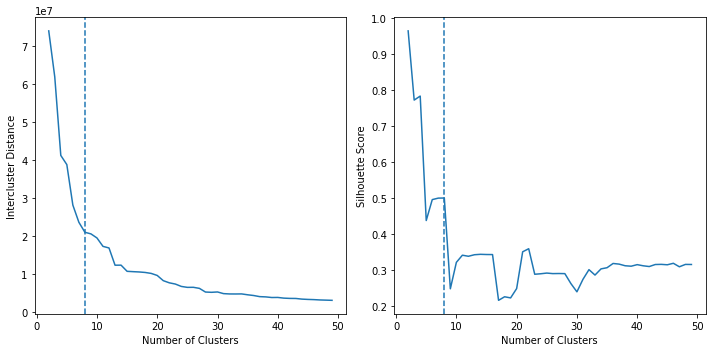

In [24]:
import matplotlib.pyplot as plt
def make_plot(data, y_label, ax, k0):
    ax.plot(data[:,0], data[:,1])
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel(y_label)
    ax.axvline(x=k0, linestyle='--')
k0 = 8
fig, ax = plt.subplots(1,2, figsize =(10,5))
make_plot(data=Lcost_array, y_label='Intercluster Distance', ax=ax[0], k0=k0)
make_plot(data=silhouette_scores_array, y_label='Silhouette Score', ax=ax[1], k0=k0)
plt.tight_layout()
#plt.savefig("../data/processed/"+data_path+"/BKmeans/ncluster_performance.pdf")

The predictions seem pretty stable. With k=1  clusters' sizes and centroid positions do not depend strongly on the seed

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [19]:
for seed in range(10):
    BKMeans_=BisectingKMeans(featuresCol='features', k=k0, seed = seed)
    BKMeans_Model=BKMeans_.fit(assembled_data)
    BKMeans_transform=BKMeans_Model.transform(assembled_data)
    print("seed=", seed, "\t",
        list(BKMeans_Model.summary.predictions.groupby("prediction").count().sort(desc("count")).toPandas()["count"]),
        "\t",
        [round(C[0],2) for C in BKMeans_Model.clusterCenters()]
    )

seed= 0 	 [1378, 1250, 928, 824, 490, 384, 359, 359] 	 [0.06, 0.09, 0.12, 0.12, 0.0, 0.2, 0.25, 0.17]
seed= 1 	 [1787, 1692, 736, 399, 394, 363, 313, 288] 	 [0.08, 0.1, 0.08, 0.08, 0.12, 0.26, 0.17, 0.14]
seed= 2 	 [1884, 1779, 677, 437, 385, 301, 268, 241] 	 [0.0, 0.05, 0.29, 0.25, 0.14, 0.16, 0.14, 0.24]
seed= 3 	 [1665, 1337, 969, 577, 490, 409, 384, 141] 	 [0.0, 0.19, 0.2, 0.26, 0.08, 0.07, 0.12, 0.12]
seed= 4 	 [2088, 1336, 667, 514, 507, 479, 211, 170] 	 [0.0, 0.0, 0.21, 0.39, 0.08, 0.12, 0.11, 0.12]
seed= 5 	 [1947, 1389, 1040, 576, 332, 322, 197, 169] 	 [0.1, 0.13, 0.07, 0.12, 0.0, 0.02, 0.5, 0.27]
seed= 6 	 [2072, 1196, 817, 488, 400, 374, 341, 284] 	 [0.06, 0.09, 0.07, 0.22, 0.12, 0.18, 0.14, 0.14]
seed= 7 	 [1649, 1598, 823, 488, 415, 374, 328, 297] 	 [0.09, 0.02, 0.1, 0.08, 0.12, 0.18, 0.14, 0.14]
seed= 8 	 [1708, 1207, 1052, 518, 488, 374, 362, 263] 	 [0.1, 0.08, 0.04, 0.17, 0.12, 0.18, 0.14, 0.15]
seed= 9 	 [1687, 1235, 954, 721, 449, 393, 310, 223] 	 [0.09, 0.05, 0.06, 0

Here are mean citation counts per clusters

In [15]:
from pyspark.sql.functions import stddev, count as _count, lit

BKMeans_Model = BisectingKMeans(featuresCol='features', k=8, seed = 1).fit(assembled_data)
tab = BKMeans_Model.summary.predictions.\
    groupby("prediction").agg(
        mean("citation_count").alias("mean"),
        # stddev("citation_count").alias("sigma"),
        _count(lit(1)).alias("count")
    ).\
    select(col("prediction").alias("cluster"), col("count"), col("mean").cast("int")).\
    sort(asc("count"))
tab

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


cluster,count,mean
7,1,20
6,19,321
5,53,182
4,245,113
0,815,13
3,1016,79
1,1208,27
2,1946,46


In [16]:
print(tab.toPandas().to_latex(index = False))

\begin{tabular}{rrr}
\toprule
 cluster &  count &  mean \\
\midrule
       7 &      1 &    20 \\
       6 &     19 &   321 \\
       5 &     53 &   182 \\
       4 &    245 &   113 \\
       0 &    815 &    13 \\
       3 &   1016 &    79 \\
       1 &   1208 &    27 \\
       2 &   1946 &    46 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_29285/2569547265.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab.toPandas().to_latex(index = False))


In [19]:
tab.toPandas().to_csv("../data/processed/"+data_path+"/bkmeans_mean_table.csv")

Let us do some visuals. PCA is very usefull for this

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


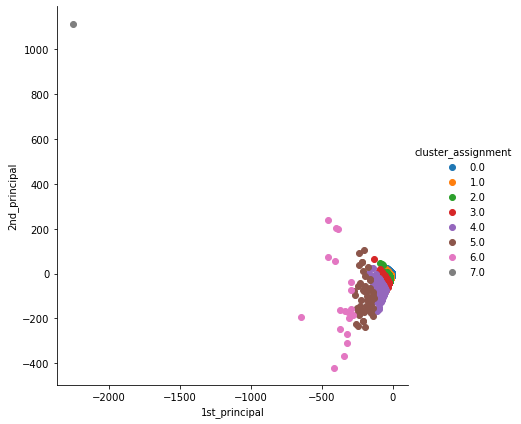

In [17]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

import numpy as np
X_pca = pca_transformed.rdd.map(lambda row: row.pca).collect()
X_pca = np.array(X_pca)

BKMeans_transform = BKMeans_Model.summary.predictions
cluster_assignment = np.array(BKMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
# plt.xlim(0, 750)
# plt.ylim(-500, 1000)
plt.savefig("../data/processed/"+data_path+"/bkmeans_pca.pdf")

The clustering is evident

In [39]:
predictions = BKMeans_Model.summary.predictions

In [40]:
predictions.groupby("prediction").count().sort(desc("count")).collect()[-2][0]

6

In [66]:
row = predictions.describe().filter("summary == 'max'").collect()[0]
keyword_fields = [c for c in row.asDict().keys() if row.asDict()[c] == '1']

In [79]:

predictions.filter("prediction == 3").select(keyword_fields).describe()

summary,CP__violation,Feynman_graph,Feynman_graph__higher-order,Higgs_particle__mass,bibliography,critical_phenomena,effective_Lagrangian,electron_positron__annihilation,electroweak_interaction,neutrino__cosmic_radiation,neutrino__mass,neutrino__mixing_angle,neutrino__oscillation,neutrino__solar,numerical_calculations,numerical_calculations__interpretation_of_experiments,p_p__inclusive_reaction,perturbation_theory__higher-order,quantum_chromodynamics,supersymmetry
count,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
mean,0.27906976744186046,0.023255813953488372,0.023255813953488372,0.0,0.16279069767441862,0.023255813953488372,0.023255813953488372,0.046511627906976744,0.3488372093023256,0.09302325581395349,0.06976744186046512,0.0,0.13953488372093023,0.11627906976744186,0.023255813953488372,0.023255813953488372,0.0,0.0,0.3488372093023256,0.27906976744186046
stddev,0.4538502687508102,0.15249857033260464,0.15249857033260467,0.0,0.3735436838188142,0.15249857033260467,0.15249857033260467,0.21308263231644634,0.4822428221704121,0.293902598732179,0.25776963111323353,0.0,0.350604603563426,0.32435300622428814,0.15249857033260467,0.15249857033260467,0.0,0.0,0.48224282217041203,0.45385026875081025
min,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
max,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,1
